In [ ]:
from country_scraping import agglomerate_countries
from config import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
import sys
import os.path as op

sys.path.insert(0, '.') # project folder


from country_analysis import get_region, custom_color_map, get_country_fullname

# Country scraping

We performed country scraping trough the youtube API but also trough a Webarchive of socialblade, this proved to be quite long and the full pipeline can be found under pipelines/country_scraping.ipynb. For the categorisation special values are 'deleted' - channels for which the youtube API did not have any info anymore, 'no_country' - channels with no info on youtube and no country indicated on the webarchive, 'no_rec' - channels with no info on youtube and no record on the archive. We report here the results of the scraping:

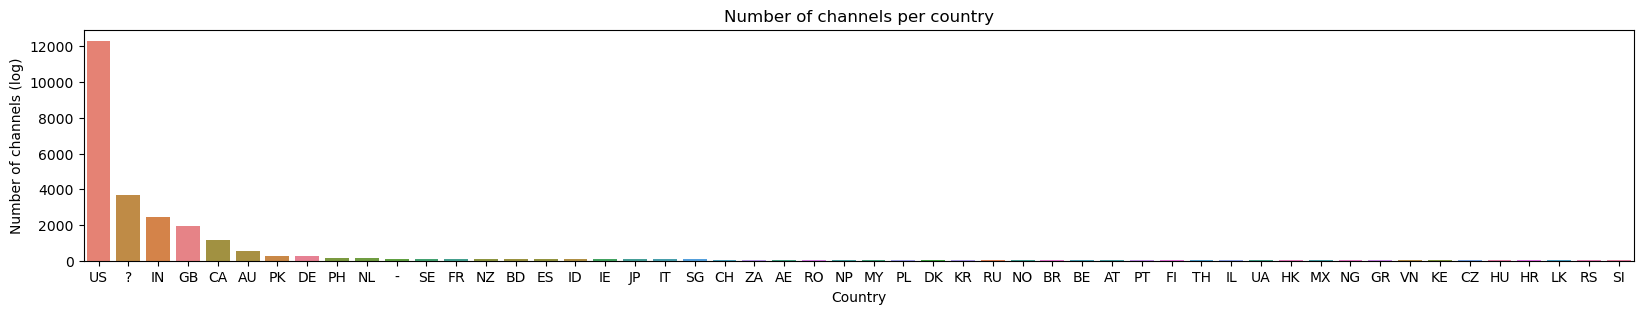

In [ ]:
countries = pd.read_csv(op.join(path_deriv, 'countries.csv'), index_col=0, dtype={'country': str, 'channel_id': str})
filter = 20
value_countss = countries['country'].value_counts()
countries['country'] = countries['country'].apply(lambda x: 'Other' if type(x) == str and value_countss[x] < filter  else x)
countries = countries[countries.country != 'Other']

# deleted and no_rec we dont have information so question mark
countries[countries.country == 'deleted'] = '?'
countries[countries.country == 'no_country'] = '-'
countries[countries.country == 'no_rec'] = '?'
countries.country = countries.country.fillna('?') # just in case

fig, ax = plt.subplots(figsize=(20, 3))
sns.countplot(x='country', data=countries, order = countries['country'].value_counts(dropna=False).index, hue = 'country', ax=ax)
ax.set_title('Number of channels per country')
ax.set_xlabel('Country')
ax.set_ylabel('Number of channels (log)')
#ax.legend_.remove()
plt.show()

In [ ]:
# Another view but on the filtered data
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

ch_per_country = pd.read_csv(op.join(path_deriv, 'channels_per_country.csv'), index_col=0)
quantiles, bins = pd.qcut(ch_per_country['# channels'], q=40, retbins=True, labels = False,duplicates='drop')
bins = [(int(b), id) for id, b in enumerate(bins) if b != 1.25 and int(b) in [1,5,11,27,35,40, 53,75,96] or b>100 ]
line_color = 'white'#"RebeccaPurple" 'darkgray' 

fig = go.Figure(data=go.Choropleth(
    locations = ch_per_country.country_iso3,
    #z = ch_per_country['# channels'].astype(float),
    z = quantiles,
    text = ch_per_country.country_name,
    customdata=ch_per_country['# channels'],
    colorscale = 'Spectral',#'Blues',
    colorbar=dict(
        tickvals=[str(b) for id, b in bins],
        ticktext=[str(id) for id, b in bins],  # Label quantiles
        x = 1,
        tickfont=dict(size=8.5)
    ),
    showscale=True,
    hovertemplate="<b>%{text}</b><extra>%{customdata:,.0f} channels</extra>",
    autocolorscale=False,
    reversescale=True,
    marker_line_color=line_color,
    marker_line_width=0.5,
    colorbar_tickprefix = '',
    colorbar_title = '# channels',
    
))

fig.update_geos(
        showframe=True,
        showcoastlines=True, coastlinecolor=line_color, coastlinewidth=0.8,
        showocean=True, oceancolor="LightBlue",
        showlakes=False, lakecolor="Blue",
        showrivers=False, rivercolor="Blue",
        showland=True, landcolor="#fff0db",
        projection_type='equirectangular'
    )

fig.update_layout(autosize=True)
fig.show()

#fig.write_html(op.join(path_country_fig, 'country_channel.html'), auto_open=True)

# Keyword search

Since BART proved to be too long and Bert not reliable enough, keyword search was implemented to categorise the data. We used a human and bottom up approach, aiming to categorise spam videos first then big observed big categories, then the rest of the data in an order that makes sense semantically, since categorised videos are no longer considered for further categorisation. The order of classification is thus important, even crucial. Since looking for single expressions is way faster than fancy regexp combinations we pay particular attention to chosen words, for them not to be too general and warn of high frequency words in nltk word frequency distributions. We used personal knowledge, chatGPT, the web, youtube, twitch and copilot to curate the lists of expressions for the categories. This was an iterative process and included a quality control step to further refine the quality of the classification, aiming to preferentially have smaller categories than lots of videos but wrongfully categorised. The categories can be found in config.py and the result is summarised here. 

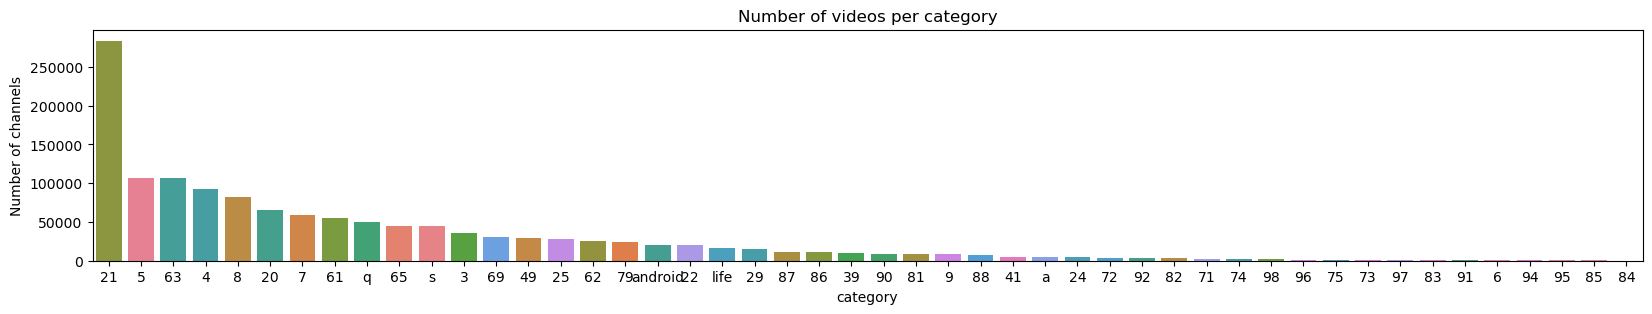

In [ ]:
edu = pd.DataFrame()
for i in range(N_BATCHES):
    batch = pd.read_csv(path_edu.format(i), index_col=0).drop(columns = ['description', 'crawl_date', 'title', 'tags'])
    edu = pd.concat([edu, batch])
    del batch

edu = edu.rename(columns={'channel_id': 'channel', 'categories': 'vid_category'})
classif = pd.read_csv(path_classified)[['display_id', 'category']]
edu = edu.merge(classif, on='display_id', how='left')
to_plot = edu[edu.category != 'unclass'].copy().drop(columns = ['text'])

fig, ax = plt.subplots(figsize=(20, 3))
sns.countplot(x='category', data=to_plot, order = to_plot.category.value_counts().index, hue = 'category', ax=ax)
ax.set_title('Number of videos per category')
ax.set_xlabel('category')
ax.set_ylabel('Number of channels')
plt.show()

# Countries results

In [ ]:
country_category = pd.read_csv(op.join(path_deriv, 'country_category.csv'), index_col=0)
country_category = edu.groupby(['country', 'category']).count().reset_index()[['country', 'category', 'channel']].rename(columns = {'channel': '# videos'})
country_category['subcategory'] = country_category.category.apply(lambda x: content_categories[x].capitalize())
country_category['country_name'] = country_category.country.apply(get_country_fullname)
fig = px.sunburst(
    country_category,
    custom_data='subcategory',
    path=['country_name', 'category'],  # Specify the hierarchy
    values='# videos',  # Values determine the size of each slice
    #title="Sunburst Plot of Country and Category"
)
fig.update_traces(
    hovertemplate="<b>%{label}: %{customdata}</b><br># videos: %{value}"
)

fig.update_layout(autosize=True)
fig.show()

#fig.write_html(op.join(path_country_fig,'country_sunburst.html'), auto_open=True)

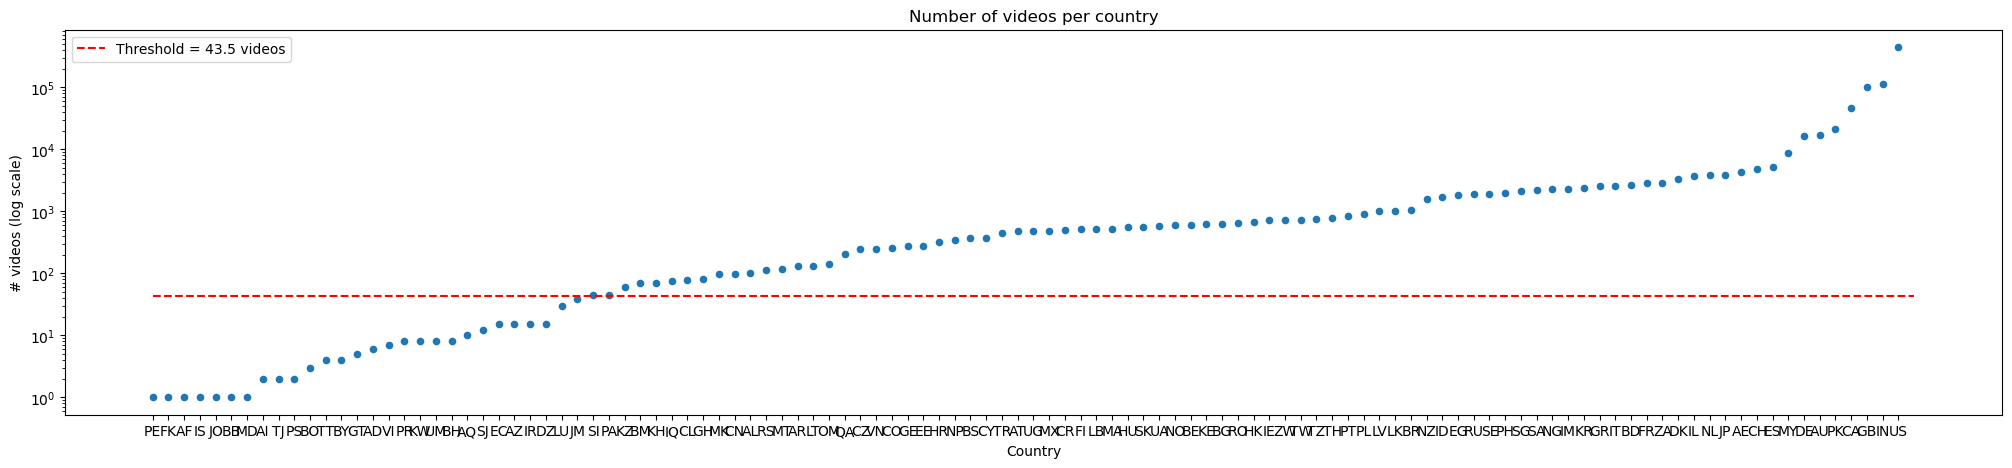

In [ ]:
# for numerical data
numericals = pd.read_csv(op.join(path_deriv, 'country_numericals.csv'), index_col=0)
quantile_threshold = numericals['# videos'].quantile(0.25)

fig, ax = plt.subplots(1, 1, figsize=(25,5))
numericals.sort_values(by = '# videos').plot(kind='scatter', y='# videos', x='country', logy=True, figsize=(25,5), title='Number of videos per country', ax=ax)
ax.plot([0, len(numericals)], [quantile_threshold, quantile_threshold], 'r--', label=f'Threshold = {quantile_threshold} videos')
ax.set_xlabel('Country')
ax.set_ylabel('# videos (log scale)')
plt.legend()
# filter at 25% quantile
numericals = numericals[numericals['# videos'] > quantile_threshold]

In [ ]:

numericals['like_per_view_per_video'] = numericals['like_per_view'] / numericals['# videos']
numericals['dislike_per_view_per_video'] = numericals['dislike_per_view'] / numericals['# videos']
numericals['like_per_vid'] = numericals['like_count'] / numericals['# videos']
numericals['dislike_per_vid'] = numericals['dislike_count'] / numericals['# videos']
numericals['country_name'] = numericals.country.apply(get_country_fullname)
numericals['Region'] = numericals.country_name.apply(get_region)
numericals.Region = numericals.Region.apply(lambda x: 'Oceania' if x == 'Australia and New Zealand' else x)

In [ ]:
numericals['color'] = numericals['region'].map(custom_color_map)

fig = px.scatter(numericals, x="like_per_vid", y="dislike_per_vid",
	         size="view_count", color="Region",
                 hover_name="country_name", 
                 color_discrete_map = custom_color_map,
                 log_x = False, log_y=False, 
                 custom_data=['country_name', '# videos'],
                 size_max=50,
                 text="country",
    )

fig.update_layout(
    xaxis=dict(title="Likes per video",tickformat=".1s"),
    yaxis=dict(title="Dislikes per video",tickformat=".1s"),
    #plot_bgcolor="lightgray", 
    paper_bgcolor="white", 
    showlegend=True ,
    legend=dict(font=dict(size=11)),
)
fig.update_traces( # change text inside bubbles
    textfont=dict(size=12, color='white'),
    textposition='middle center',
    hovertemplate="<b>%{customdata[0]}</b><br> Likes per video: %{x:.0f} <br> Dislikes per video: %{y:.0f}<br> Median Views: %{marker.size:.0f} <br> # videos: %{customdata[1]:,.0f}",
    hoverlabel=dict(font=dict(size=12)),
    
)

lines = [
    {"slope": 0.5, "intercept": 0, "name": "1/2"},
    {"slope": 0.33, "intercept": 0, "name": "1/3"}
]

# Add lines to the plot
for line in lines:
    x_vals = np.array([0, 10])  # Define the x-range for the line
    y_vals = line["slope"] * x_vals + line["intercept"]  # Calculate y = mx + b
    fig.add_trace(
        go.Scatter(
            x=x_vals, 
            y=y_vals, 
            mode="lines", 
            name=line["name"], 
            line=dict(dash="dash")  # Optional: make the lines dashed
        )
    )
    
# fig.write_html(op.join(path_country_fig,'country_likes_dislikes.html'), auto_open=True)
fig.show()

In [ ]:
# compute like dislike ratio
numericals['dislike_like_ratio'] = numericals['dislike_count'] / numericals['like_count']
numericals.sort_values(by='dislike_like_ratio', ascending=True)[['country_name', 'dislike_like_ratio']]
numericals[numericals.country.isin(['AT', 'JP', 'TW', 'RO', 'RS', 'LU', 'VN','KR'])][['country_name',  'dislike_like_ratio']].sort_values(by='dislike_like_ratio', ascending=False)

,country_name,dislike_like_ratio
120,Viet Nam,0.378424
95,Serbia,0.357258
70,Luxembourg,0.294357
64,"Korea, Republic of",0.260530
61,Japan,0.083739
111,"Taiwan, Province of China",0.041106
8,Austria,0.035502
94,Romania,0.031121
